In [3]:
# from os import listdir, getcwd
# from os.path import join

import pyreadr

import pandas as pd
import numpy as np
#import csv

import matplotlib.pyplot as plt

#import eli5
#from eli5.sklearn import PermutationImportance

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import sksurv.metrics
from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
    brier_score
)

from sksurv.functions import StepFunction
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.ensemble import RandomSurvivalForest, GradientBoostingSurvivalAnalysis

# from pysurvival.models.parametric import GompertzModel
# from pysurvival.utils.metrics import concordance_index as ps_cindex
# from pysurvival.utils.display import integrated_brier_score as ps_ibs

import lifelines

# Load data

In [100]:
# read in data
df_train_all = pyreadr.read_r("4_modelling_data/all_train_imputed_scaled.rds")[None]
df_test_all = pyreadr.read_r("4_modelling_data/all_test_imputed_scaled.rds")[None]

In [101]:
print(np.sum(df_train_all['start_outcome'] > df_train_all['stop_outcome']))
print(np.sum(df_test_all['start_outcome'] > df_test_all['stop_outcome']))

print(np.sum(df_train_all['start_outcome'] == df_train_all['stop_outcome']))
print(np.sum(df_test_all['start_outcome'] == df_test_all['stop_outcome']))

12
18
4176
2795


In [102]:
# df_train = df_train_all[df_train_all['start_outcome'] < df_train_all['stop_outcome']]
# df_test = df_test_all[df_test_all['start_outcome'] < df_test_all['stop_outcome']]
# df_train.shape

In [105]:
print(df_train_all.shape)
df_train_all.head()

(141559, 219)


,hhidpn,age,wave_outcome,event_type_outcome,first_wave_outcome,last_wave_outcome,iwdate_outcome,birth_date_outcome,exit_date_outcome,exit_age_outcome,...,r_unemp_cat,s_unemp_cat,h_gcaany_cat,h_kcnt_cat,h_pcnt_cat,r_relgwk_cat,s_relgwk_cat,h_adebt,h_itot,h_atotb
0,10404010,52.500000,1.0,0.0,1.0,14.0,1992.333333,1939.833333,2018.583333,78.750000,...,0,-1,0,1,1,0,-1,-0.125983,-0.432570,0.828408
1,11479010,50.833333,1.0,1.0,1.0,8.0,1992.333333,1941.500000,2007.666667,66.166667,...,-1,-1,0,1,0,0,0,-0.125983,-0.549372,-1.343811
2,11667020,59.750000,1.0,1.0,1.0,9.0,1992.333333,1932.583333,2008.666667,76.083333,...,0,-1,0,1,0,1,1,-0.068570,-0.303330,-1.300540
3,12744010,58.166667,1.0,0.0,1.0,14.0,1992.333333,1934.166667,2018.333333,84.166667,...,0,0,0,1,0,0,0,-0.125983,-0.212262,0.828408
4,14028020,50.916667,1.0,0.0,1.0,14.0,1992.333333,1941.416667,2018.583333,77.166667,...,0,0,0,1,1,0,0,0.256771,0.287141,0.828408


## Format for time-varying models

In [113]:
df_train_all['age_now'] = df_train_all['age']
ages = df_train_all.groupby('hhidpn').agg({'age': 'min'})
#df_train_all['age'] = df_train_all.groupby('hhidpn').apply(lambda g: min(g.age_now))

In [114]:
ages

,age
hhidpn,
10003030,50.250000
10004010,52.500000
10013040,50.416667
10038010,56.583333
10038040,51.500000
...,...
98097030,64.916667
98121010,58.583333
99231011,68.166667


In [115]:
ages.index

Index(['10003030', '10004010', '10013040', '10038010', '10038040', '10059030',
       '10083010', '10090010', '10094010', '10097010',
       ...
       '96126040', '97589010', '97589020', '98001010', '98097020', '98097030',
       '98121010', '99231011', '99564011', '99587010'],
      dtype='object', name='hhidpn', length=23537)

In [116]:
for count, hhidpn in enumerate(ages.index):
    #df_train_all[df_train_all['hhidpn'] == hhidpn]['age'] = ages['age'][count]
    df_train_all.loc[df_train_all['hhidpn'] == hhidpn,'age'] = ages['age'][count]

In [117]:
print(df_train_all[df_train_all['hhidpn'] == '10003030']['age'])
print(df_train_all[df_train_all['hhidpn'] == '10003030']['age_now'])

35155    50.25
35721    50.25
36729    50.25
37919    50.25
39078    50.25
40155    50.25
Name: age, dtype: float64
35155    50.250000
35721    52.000000
36729    54.083333
37919    56.166667
39078    58.000000
40155    60.000000
Name: age_now, dtype: float64


In [118]:
print(df_train_all.shape)
df_train_all.head()

(141559, 220)


,hhidpn,age,wave_outcome,event_type_outcome,first_wave_outcome,last_wave_outcome,iwdate_outcome,birth_date_outcome,exit_date_outcome,exit_age_outcome,...,s_unemp_cat,h_gcaany_cat,h_kcnt_cat,h_pcnt_cat,r_relgwk_cat,s_relgwk_cat,h_adebt,h_itot,h_atotb,age_now
0,10404010,52.500000,1.0,0.0,1.0,14.0,1992.333333,1939.833333,2018.583333,78.750000,...,-1,0,1,1,0,-1,-0.125983,-0.432570,0.828408,52.500000
1,11479010,50.833333,1.0,1.0,1.0,8.0,1992.333333,1941.500000,2007.666667,66.166667,...,-1,0,1,0,0,0,-0.125983,-0.549372,-1.343811,50.833333
2,11667020,59.750000,1.0,1.0,1.0,9.0,1992.333333,1932.583333,2008.666667,76.083333,...,-1,0,1,0,1,1,-0.068570,-0.303330,-1.300540,59.750000
3,12744010,58.166667,1.0,0.0,1.0,14.0,1992.333333,1934.166667,2018.333333,84.166667,...,0,0,1,0,0,0,-0.125983,-0.212262,0.828408,58.166667
4,14028020,50.916667,1.0,0.0,1.0,14.0,1992.333333,1941.416667,2018.583333,77.166667,...,0,0,1,1,0,0,0.256771,0.287141,0.828408,50.916667


In [119]:
df_train_all['start'] = df_train_all['start_outcome'] - df_train_all['age']
df_train_all['stop'] = df_train_all['stop_outcome'] - df_train_all['age']

In [120]:
df_train_all.shape

(141559, 222)

In [121]:
np.sum(df_train_all['start'] >= df_train_all['stop'])

4188

In [122]:
df_train = df_train_all[df_train_all['start'] < df_train_all['stop']]

In [123]:
df_train.shape

(137371, 222)

In [136]:
# do the same for test data
df_test_all['age_now'] = df_test_all['age']
ages = df_test_all.groupby('hhidpn').agg({'age': 'min'})

for count, hhidpn in enumerate(ages.index):
    df_test_all.loc[df_test_all['hhidpn'] == hhidpn,'age'] = ages['age'][count]
    
df_test_all['start'] = df_test_all['start_outcome'] - df_test_all['age']
df_test_all['stop'] = df_test_all['stop_outcome'] - df_test_all['age']

df_test = df_test_all[df_test_all['start'] < df_test_all['stop']]

In [137]:
print(np.sum(df_test_all['start_outcome'] >= df_test_all['stop_outcome']))
print(df_test_all.shape)
print(df_test.shape)

2813
(94884, 222)
(92071, 222)


In [126]:
# save data
df_train.to_pickle('4_modelling_data/train_tv.pkl')
df_test.to_pickle('4_modelling_data/test_tv.pkl')

In [169]:
df_train['event'] = df_train['death_status_outcome'].astype(bool)
y_train = df_train.loc[:,['start','stop','event']]

df_test['event'] = df_test['death_status_outcome'].astype(bool)
y_test = df_test.loc[:,['start','stop','event']]

C:\Users\Irons\AppData\Local\Temp\46\ipykernel_83900\3250163005.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['event'] = df_train['death_status_outcome'].astype(bool)
C:\Users\Irons\AppData\Local\Temp\46\ipykernel_83900\3250163005.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['event'] = df_test['death_status_outcome'].astype(bool)


In [170]:
y_train

,start,stop,event
0,0.0,2.166667,False
1,0.0,2.166667,False
2,0.0,2.083333,False
3,0.0,2.166667,False
4,0.0,2.500000,False
...,...,...,...
141554,0.0,0.583333,False
141555,0.0,1.083333,False
141556,0.0,0.666667,False
141557,0.0,0.666667,False


In [176]:
drop_cols = [col for col in df_train.columns if (('age_now' == col) | ('start' == col) | ('stop' == col) | ('birth_date' in col) | ('event' == col) | ('outcome' in col))]
drop_cols

['wave_outcome',
 'event_type_outcome',
 'first_wave_outcome',
 'last_wave_outcome',
 'iwdate_outcome',
 'birth_date_outcome',
 'exit_date_outcome',
 'exit_age_outcome',
 'exit_time_outcome',
 'death_status_outcome',
 'start_outcome',
 'stop_outcome',
 'age_now',
 'start',
 'stop',
 'event']

In [173]:
x_train = df_train[df_train.columns.drop(drop_cols)]
x_test = df_test[df_test.columns.drop(drop_cols)]

In [174]:
# save data
y_train.to_pickle('4_modelling_data/y_train_tv.pkl')
x_train.to_pickle('4_modelling_data/x_train_tv.pkl')

y_test.to_pickle('4_modelling_data/y_test_tv.pkl')
x_test.to_pickle('4_modelling_data/x_test_tv.pkl')

In [175]:
y_train = df_train.loc[:,['start','stop','event']].to_records(index=False)
y_test = df_test.loc[:,['start','stop','event']].to_records(index=False)

## Lifelines dataframe format

In [178]:
drop_cols_ll = [col for col in df_train.columns if (('age_now' == col) | ('birth_date' in col) | ('outcome' in col))]
drop_cols_ll

['wave_outcome',
 'event_type_outcome',
 'first_wave_outcome',
 'last_wave_outcome',
 'iwdate_outcome',
 'birth_date_outcome',
 'exit_date_outcome',
 'exit_age_outcome',
 'exit_time_outcome',
 'death_status_outcome',
 'start_outcome',
 'stop_outcome',
 'age_now']

In [179]:
# lifelines dataframe format
df_train_ll = df_train[df_train.columns.drop(drop_cols_ll)]
df_test_ll = df_test[df_test.columns.drop(drop_cols_ll)]

## Misc data exploration

(array([  0.,   0.,   0.,   0.,   0., 313.,   0.,   0.,   0.,   0.]),
 array([12.5, 12.6, 12.7, 12.8, 12.9, 13. , 13.1, 13.2, 13.3, 13.4, 13.5]),
 <BarContainer object of 10 artists>)

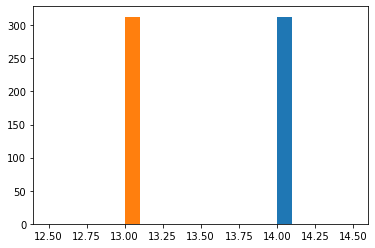

In [23]:
inds = np.where((df_train['exit_time_outcome'] < 1) & 
                (df_train['exit_time_outcome'] > 0) &
                (df_train['event_type_outcome'] == 0))
plt.hist(df_train.iloc[inds]['last_wave_outcome'])
plt.hist(df_train.iloc[inds]['first_wave_outcome'])

In [24]:
df_train.columns[0:30]

Index(['hhidpn', 'age', 'wave_outcome', 'event_type_outcome',
       'first_wave_outcome', 'last_wave_outcome', 'iwdate_outcome',
       'birth_date_outcome', 'exit_date_outcome', 'exit_age_outcome',
       'exit_time_outcome', 'death_status_outcome', 'start_outcome',
       'stop_outcome', 's_cidimde3_cat', 's_cidisymp_cat', 'r_rested_cat',
       's_rested_cat', 'r_rxpsych_cat', 's_rxpsych_cat', 'r_trpsych',
       's_trpsych', 'r_lifeinv', 's_lifeinv', 'r_nlfins', 's_nlfins',
       'r_witwill_cat', 's_witwill_cat', 'r_wlifein_cat', 's_wlifein_cat'],
      dtype='object')

In [25]:
df_train.iloc[inds]['iwdate_outcome']

13683     2017.750000
13691     2017.833333
13694     2017.833333
13698     2017.916667
13699     2017.916667
             ...     
142439    2018.333333
142440    2018.333333
142442    2018.333333
142443    2018.333333
142444    2018.333333
Name: iwdate_outcome, Length: 313, dtype: float64

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

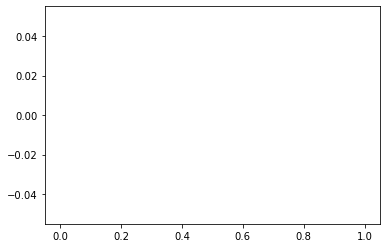

In [26]:
inds = np.where((df_train['exit_time_outcome'] == 0))
plt.hist(df_train.iloc[inds]['last_wave_outcome'] == df_train.iloc[inds]['first_wave_outcome'])

## Load survival objects

In [5]:
# read in data
# path = "4_Predictions/time_age_comp/"
path = ''
y_train_age = pd.read_pickle(path + "data/y_train_age.pkl")
y_test_age = pd.read_pickle(path + "data/y_test_age.pkl")

y_train_time = pd.read_pickle(path + "data/y_train_time.pkl")
y_test_time = pd.read_pickle(path + "data/y_test_time.pkl")

In [6]:
print(y_train_time.dtype.names)
print(y_train_age.dtype.names)

('event_type_outcome', 'exit_time_outcome')
('event_type_outcome', 'exit_age_outcome')


In [7]:
x_train_time = pd.read_pickle(path + "data/X_train_time.pkl")
x_test_time = pd.read_pickle(path + "data/X_test_time.pkl")

x_train_age = pd.read_pickle(path + "data/X_train_age.pkl")
x_test_age = pd.read_pickle(path + "data/X_test_age.pkl")

In [8]:
# # write data to csv
# import pickle as pkl
# import pandas as pd

# with open(path + "data/y_test_age.pkl", "rb") as f:
#     object = pkl.load(f)
    
# df = pd.DataFrame(object)
# df.to_csv(path + "data/y_test_age.csv")

In [9]:
# add left truncation times
y_train_age_lt = pd.DataFrame(y_train_age)
y_train_age_lt['Start'] = np.array(x_train_time['age'])
y_train_age_lt['Stop'] = np.array(y_train_age_lt['exit_age_outcome'])
y_train_age_lt['Event'] = np.array(y_train_age_lt['event_type_outcome'])
y_train_age_lt = y_train_age_lt.loc[:,['Start','Stop','Event']].to_records(index=False)

y_test_age_lt = pd.DataFrame(y_test_age)
y_test_age_lt['Start'] = np.array(x_test_time['age'])
y_test_age_lt['Stop'] = np.array(y_test_age_lt['exit_age_outcome'])
y_test_age_lt['Event'] = np.array(y_test_age_lt['event_type_outcome'])
y_test_age_lt = y_test_age_lt.loc[:,['Start','Stop','Event']].to_records(index=False)

In [10]:
y_train_age_lt

rec.array([(52.5       , 78.75      , False),
           (59.33333333, 76.16666667,  True),
           (52.16666667, 62.5       , False), ...,
           (51.58333333, 51.58333333, False),
           (51.08333333, 53.        , False),
           (53.83333333, 55.41666667, False)],
          dtype=[('Start', '<f8'), ('Stop', '<f8'), ('Event', '?')])

In [11]:
# add left truncation times
y_train_time_lt = pd.DataFrame(y_train_time)
y_train_time_lt['Start'] = 0 
y_train_time_lt['Stop'] = np.array(y_train_time_lt['exit_time_outcome'])
y_train_time_lt['Event'] = np.array(y_train_time_lt['event_type_outcome'])
y_train_time_lt = y_train_time_lt.loc[:,['Start','Stop','Event']].to_records(index=False)

y_test_time_lt = pd.DataFrame(y_test_time)
y_test_time_lt['Start'] = 0
y_test_time_lt['Stop'] = np.array(y_test_time_lt['exit_time_outcome'])
y_test_time_lt['Event'] = np.array(y_test_time_lt['event_type_outcome'])
y_test_time_lt = y_test_time_lt.loc[:,['Start','Stop','Event']].to_records(index=False)

In [12]:
y_train_time_lt

rec.array([(0, 26.25      , False), (0, 16.83333333,  True),
           (0, 10.33333333, False), ..., (0,  6.16666667, False),
           (0,  7.25      , False), (0,  0.66666667, False)],
          dtype=[('Start', '<i8'), ('Stop', '<f8'), ('Event', '?')])

In [13]:
# add left truncation times
y_train_time_age_lt = pd.DataFrame(y_train_age)
y_train_time_age_lt['Start'] = np.array(x_train_time['age'])
y_train_time_age_lt['Stop'] = np.array(y_train_time['exit_time_outcome'] + x_train_time['age'])
y_train_time_age_lt['Event'] = np.array(y_train_time_age_lt['event_type_outcome'])
y_train_time_age_lt = y_train_time_age_lt.loc[:,['Start','Stop','Event']].to_records(index=False)

y_test_time_age_lt = pd.DataFrame(y_test_age)
y_test_time_age_lt['Start'] = np.array(x_test_time['age'])
y_test_time_age_lt['Stop'] = np.array(y_test_time['exit_time_outcome'] + x_test_time['age'])
y_test_time_age_lt['Event'] = np.array(y_test_time_age_lt['event_type_outcome'])
y_test_time_age_lt = y_test_time_age_lt.loc[:,['Start','Stop','Event']].to_records(index=False)

In [14]:
y_train_time_age_lt

rec.array([(52.5       , 78.75      , False),
           (59.33333333, 76.16666667,  True),
           (52.16666667, 62.5       , False), ...,
           (51.58333333, 57.75      , False),
           (51.08333333, 58.33333333, False),
           (53.83333333, 54.5       , False)],
          dtype=[('Start', '<f8'), ('Stop', '<f8'), ('Event', '?')])

# Fit time-varying Cox model

In [188]:
from lifelines import CoxTimeVaryingFitter

In [196]:
ctv = CoxTimeVaryingFitter(penalizer=0.01)
ctv.fit(df_train_ll, id_col="hhidpn", event_col="event", start_col="start", stop_col="stop", show_progress=True)

Iteration 1: norm_delta = 0.99111, step_size = 0.95000, ll = -88540.07280, newton_decrement = 11163.55741, seconds_since_start = 28.6
Iteration 2: norm_delta = 0.81495, step_size = 0.95000, ll = -91161.47681, newton_decrement = 14254.95061, seconds_since_start = 57.2
Iteration 3: norm_delta = 0.91802, step_size = 0.95000, ll = -85332.43819, newton_decrement = 6533.28783, seconds_since_start = 85.7
Iteration 4: norm_delta = 0.40104, step_size = 0.93100, ll = -83820.88273, newton_decrement = 3135.77321, seconds_since_start = 114.1
Iteration 5: norm_delta = 0.18056, step_size = 0.91238, ll = -81059.91208, newton_decrement = 201.81943, seconds_since_start = 143.1
Iteration 6: norm_delta = 0.01227, step_size = 1.00000, ll = -80866.77224, newton_decrement = 1.02098, seconds_since_start = 172.3
Iteration 7: norm_delta = 0.00012, step_size = 1.00000, ll = -80865.74462, newton_decrement = 0.00011, seconds_since_start = 200.8
Iteration 8: norm_delta = 0.00000, step_size = 1.00000, ll = -80865.74

<lifelines.CoxTimeVaryingFitter: fitted with 137371 periods, 23455 subjects, 9555 events>

C:\ProgramData\Anaconda3\envs\nick\lib\site-packages\lifelines\utils\printer.py:62: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return summary_df[columns].to_latex(float_format="%." + str(self.decimals) + "f")


<lifelines.CoxTimeVaryingFitter: fitted with 137371 periods, 23455 subjects, 9555 events>
         event col = 'event'
         penalizer = 0.01
number of subjects = 23455
 number of periods = 137371
  number of events = 9555
partial log-likelihood = -80865.74
  time fit was run = 2022-08-05 13:58:43 UTC

---
                         coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                      
age                      0.04       1.04       0.00             0.03             0.04                 1.03                 1.04
s_cidimde3_cat           0.03       1.03       0.05            -0.07             0.13                 0.93                 1.13
s_cidisymp_cat           0.01       1.01       0.02            -0.02             0.04                 0.98                 1.04
r_rested_cat            -0.06       0.94       0.01            -0.09            -0.03                 0.92                 0.97
s_rested_cat            -0.02       0.98       0.02            -0.06             0.01                 0.95                 1.01
r_rxpsych               -0.01       0.99       0.01            -0.03             0.01                 0.97                 1.01
s_rxpsych                0.02       1.02       0.02            -0.03             0.06                 0.98                 1.06
r_trpsych               -0.02       0.98       0.01            -0.03             0.00                 0.97                 1.00
s_trpsych                0.01       1.01       0.01            -0.01             0.03                 0.99                 1.03
r_lifeinv                0.00       1.00       0.01            -0.02             0.02                 0.98                 1.02
s_lifeinv               -0.02       0.98       0.01            -0.04             0.01                 0.96                 1.01
r_nlfins                 0.01       1.01       0.01            -0.01             0.03                 0.99                 1.03
s_nlfins                 0.02       1.02       0.01            -0.01             0.05                 0.99                 1.05
r_witwill_cat           -0.02       0.98       0.02            -0.06             0.03                 0.94                 1.03
s_witwill_cat           -0.02       0.98       0.02            -0.07             0.03                 0.94                 1.03
r_wlifein_cat           -0.06       0.94       0.03            -0.11            -0.01                 0.89                 0.99
s_wlifein_cat            0.01       1.01       0.03            -0.04             0.07                 0.96                 1.07
r_wtrust_cat            -0.07       0.93       0.07            -0.20             0.07                 0.82                 1.07
s_wtrust_cat             0.03       1.03       0.05            -0.07             0.12                 0.94                 1.13
r_lifeins_fam_cat       -0.06       0.94       0.03            -0.12            -0.01                 0.89                 0.99
s_will_fam_cat           0.04       1.04       0.04            -0.04             0.11                 0.97                 1.11
r_ftrhlp_cat             0.08       1.08       0.04            -0.01             0.16                 0.99                 1.18
s_ftrhlp_cat             0.02       1.02       0.02            -0.01             0.05                 0.99                 1.06
r_mealhlp_cat            0.17       1.19       0.03             0.10             0.24                 1.11                 1.27
s_mealhlp_cat           -0.06       0.94       0.04            -0.15             0.02                 0.86                 1.02
r_medhlp_cat             0.09       1.10       0.04             0.02             0.17                 1.02                 1.18
s_medhlp_cat            -0.06       0.94       0.05            -0.16             0.03                 0.8

<AxesSubplot:xlabel='log(HR) (95% CI)'>

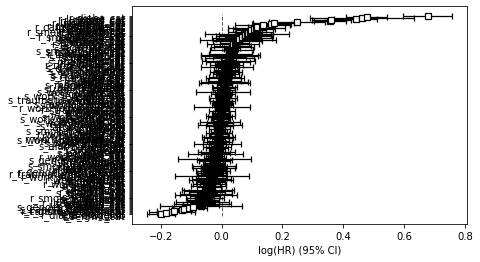

In [197]:
ctv.print_summary()
ctv.plot()

In [198]:
ctv.params_

covariate
age               0.037488
s_cidimde3_cat    0.029526
s_cidisymp_cat    0.013026
r_rested_cat     -0.059876
s_rested_cat     -0.024864
                    ...   
r_relgwk_cat     -0.198834
s_relgwk_cat     -0.053543
h_adebt          -0.002649
h_itot           -0.048394
h_atotb          -0.016255
Length: 206, dtype: float64

In [205]:
ctv.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
age,0.037488,1.038199,0.001738,0.034082,0.040894,1.034669,1.041741,0.0,21.573713,3.171861e-103,340.493264
s_cidimde3_cat,0.029526,1.029966,0.049404,-0.067304,0.126356,0.934911,1.134686,0.0,0.597649,5.500742e-01,0.862302
s_cidisymp_cat,0.013026,1.013111,0.015177,-0.016719,0.042772,0.983420,1.043699,0.0,0.858305,3.907239e-01,1.355779
r_rested_cat,-0.059876,0.941882,0.014432,-0.088161,-0.031590,0.915613,0.968903,0.0,-4.148947,3.340085e-05,14.869756
s_rested_cat,-0.024864,0.975442,0.016107,-0.056433,0.006705,0.945130,1.006727,0.0,-1.543702,1.226605e-01,3.027257
...,...,...,...,...,...,...,...,...,...,...,...
r_relgwk_cat,-0.198834,0.819686,0.023111,-0.244131,-0.153538,0.783385,0.857668,0.0,-8.603532,7.729986e-18,56.844240
s_relgwk_cat,-0.053543,0.947865,0.024802,-0.102154,-0.004932,0.902891,0.995080,0.0,-2.158814,3.086459e-02,5.017904
h_adebt,-0.002649,0.997355,0.013094,-0.028314,0.023016,0.972083,1.023283,0.0,-0.202293,8.396873e-01,0.252076


In [203]:
# save model object
import pickle

#ctv.to_pickle('5_predictions/model_objects/cph_tv_model.pkl')
with open('5_predictions/model_objects/cph_tv_model.pkl', 'wb') as f:
    pickle.dump(ctv, f) # saving my trained cph model as my.pickle

In [207]:
ctv.predict_partial_hazard(df_train_ll)

0         0.199517
1         2.290774
2         0.188942
3         0.612746
4         0.208246
            ...   
137366    0.283516
137367    0.186312
137368    0.504529
137369    0.226198
137370    0.540699
Length: 137371, dtype: float64

In [250]:
ctv.baseline_cumulative_hazard_.index

Float64Index([0.08333333333325754, 0.08333333333348492, 0.16666666666651508,
              0.16666666666674246,                0.25, 0.33333333333325754,
               0.3333333333334849,  0.4166666666665151, 0.41666666666674246,
                              0.5,
              ...
               25.916666666666742,                26.0,  26.083333333333258,
               26.083333333333485,  26.166666666666515,  26.166666666666742,
                            26.25,  26.333333333333258,  26.416666666666742,
                             26.5],
             dtype='float64', length=527)

In [259]:
ctv.baseline_cumulative_hazard_

,baseline hazard
0.083333,0.000339
0.083333,0.000479
0.166667,0.000761
0.166667,0.001083
0.250000,0.001489
...,...
26.166667,0.585085
26.250000,0.587567
26.333333,0.590859
26.416667,0.596791


In [264]:
ctv_func = StepFunction(x = ctv.baseline_cumulative_hazard_.index, 
                        y = np.array(ctv.baseline_cumulative_hazard_['baseline hazard']))
ctv_func(times[1:27])

array([0.00788226, 0.01862465, 0.03017722, 0.04346365, 0.05606764,
       0.07089889, 0.08443839, 0.10292492, 0.1181093 , 0.13653003,
       0.15310873, 0.17324956, 0.19159372, 0.21385354, 0.23528338,
       0.26080253, 0.28529064, 0.31426309, 0.3403518 , 0.36923981,
       0.39712146, 0.42903288, 0.45883308, 0.50013006, 0.53174089,
       0.56725479])

In [221]:
times = np.arange(0,28,1);times

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27])

In [222]:
km = StepFunction(
    *kaplan_meier_estimator(event = df_train_ll['event'], 
                           time_enter = df_train_ll['start'], 
                           time_exit = df_train_ll['stop']))

km(times)

array([1.        , 0.98372867, 0.96323129, 0.94005779, 0.91648351,
       0.89370635, 0.8693119 , 0.84672275, 0.81709726, 0.79158931,
       0.76248996, 0.73750243, 0.70979257, 0.68478671, 0.65603417,
       0.62808138, 0.59785678, 0.57034785, 0.53952759, 0.5127953 ,
       0.48562766, 0.46048307, 0.43392537, 0.41013919, 0.38169507,
       0.36144868, 0.34179142, 0.32167316])

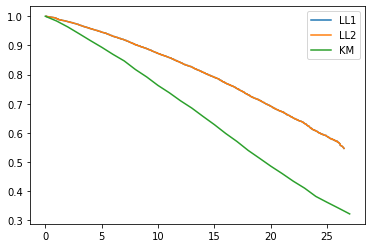

In [243]:
plt.plot(ctv.baseline_cumulative_hazard_.index,np.exp(-ctv.baseline_cumulative_hazard_['baseline hazard']),label = 'LL1')
plt.plot(ctv.baseline_survival_.index,ctv.baseline_survival_['baseline survival'],label = 'LL2')
plt.plot(times,km(times),label = 'KM')
plt.legend()

In [200]:
# get predicted survival curves
ctv.predict_survival_function(df_train_ll)

AttributeError: 'CoxTimeVaryingFitter' object has no attribute 'predict_survival_function'

# Fit Gompertz model

In [15]:
x_train_time.shape

(24546, 174)

In [16]:
y_train_time

rec.array([(False, 26.25      ), ( True, 16.83333333),
           (False, 10.33333333), ..., (False,  6.16666667),
           (False,  7.25      ), (False,  0.66666667)],
          dtype=[('event_type_outcome', '?'), ('exit_time_outcome', '<f8')])

In [17]:
# Building training and testing sets #
# index_train, index_test = train_test_split( range(N), test_size = 0.2)
# data_train = dataset.loc[index_train].reset_index( drop = True )
# data_test  = dataset.loc[index_test].reset_index( drop = True )

# Creating the X, T and E input
# X_train, X_test = data_train[features], data_test[features]
# T_train, T_test = data_train['time'].values, data_test['time'].values
# E_train, E_test = data_train['event'].values, data_test['event'].values
t_train = y_train_time['exit_time_outcome']
e_train = y_train_time['event_type_outcome']

t_test = y_test_time['exit_time_outcome']
e_test = y_test_time['event_type_outcome']

#### 4 - Creating an instance of the Gompertz model and fitting the data.
# Building the model
gomp_model = GompertzModel()
gomp_model.fit(x_train_time, t_train, e_train, num_epochs=3000,
               lr=1e-2, init_method='zeros', optimizer ='adam')#, l2_reg = 1e-3)

NameError: name 'GompertzModel' is not defined

In [ ]:
# #### 5 - Cross Validation / Model Performances
# c_index = ps_cindex(gomp_model, x_test_time, t_test, e_test) #0.77
# print('C-index: {:.2f}'.format(c_index))

# ibs = ps_ibs(gomp_model, x_test_time, t_test, e_test, t_max=30,
#             figure_size=(20, 6.5) )
# print('IBS: {:.2f}'.format(ibs))

In [11]:
#### 6 - predicted survival curves
gomp_time = gomp_model.predict_survival(x_test_time)

In [12]:
gomp_time.shape

(16357, 100)

In [13]:
gomp_time

array([[1.        , 0.9989351 , 0.9978358 , ..., 0.47643688, 0.46428216,
        0.4520469 ],
       [1.        , 0.9990038 , 0.9979754 , ..., 0.49979156, 0.48785415,
        0.47581717],
       [1.        , 0.9964554 , 0.9928055 , ..., 0.08449978, 0.07752652,
        0.07092426],
       ...,
       [1.        , 0.9987421 , 0.99744385, ..., 0.4164987 , 0.40397546,
        0.39142913],
       [1.        , 0.9991877 , 0.99834895, ..., 0.5680889 , 0.5570014 ,
        0.54577065],
       [1.        , 0.9994207 , 0.99882233, ..., 0.66814584, 0.6588204 ,
        0.64931995]], dtype=float32)

## Get Gompertz curves

In [66]:
# calculate and save survival curves from gompertz model
gomp_preds = np.array([gomp_model.predict_survival(x = x_test_time, t = time) for time in times])

In [98]:
gomp_time = pd.DataFrame(np.concatenate((np.reshape(times,[times.shape[0],1]),gomp_preds),axis=1))
gomp_time.rename(columns = {0 : 'time'})

,time,1,2,3,4,5,6,7,8,9,...,16348,16349,16350,16351,16352,16353,16354,16355,16356,16357
0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.0,0.996701,0.996914,0.989048,0.996037,0.997846,0.991693,0.995331,0.992108,0.986500,...,0.996449,0.999050,0.998341,0.998289,0.999250,0.991155,0.996594,0.996104,0.997483,0.998204
2,2.0,0.991785,0.992313,0.972882,0.990135,0.994633,0.979390,0.988386,0.980416,0.966640,...,0.991160,0.997631,0.995863,0.995735,0.998130,0.978066,0.991519,0.990302,0.993728,0.995524
3,3.0,0.987668,0.988460,0.959489,0.985198,0.991937,0.969160,0.982581,0.970687,0.950243,...,0.986733,0.996439,0.993783,0.993592,0.997188,0.967189,0.987270,0.985448,0.990581,0.993274
4,4.0,0.983145,0.984224,0.944922,0.979778,0.988971,0.957993,0.976215,0.960062,0.932469,...,0.981869,0.995125,0.991493,0.991231,0.996150,0.955326,0.982602,0.980119,0.987119,0.990797
5,5.0,0.976415,0.977920,0.923535,0.971723,0.984549,0.941524,0.966765,0.944379,0.906493,...,0.974636,0.993162,0.988076,0.987710,0.994599,0.937845,0.975657,0.972198,0.981961,0.987103
6,6.0,0.970789,0.972649,0.905921,0.964999,0.980844,0.927889,0.958886,0.931386,0.885202,...,0.968593,0.991513,0.985211,0.984757,0.993296,0.923388,0.969854,0.965584,0.977643,0.984005
7,7.0,0.964618,0.966864,0.886870,0.957632,0.976772,0.913070,0.950266,0.917253,0.862286,...,0.961967,0.989697,0.982058,0.981509,0.991859,0.907691,0.963489,0.958337,0.972900,0.980598
8,8.0,0.955457,0.958272,0.859109,0.946712,0.970710,0.891337,0.937510,0.896504,0.829097,...,0.952137,0.986986,0.977360,0.976668,0.989714,0.884699,0.954043,0.947595,0.965845,0.975522
9,9.0,0.947819,0.951103,0.836430,0.937624,0.965640,0.873456,0.926914,0.879415,0.802170,...,0.943946,0.984711,0.973425,0.972614,0.987913,0.865811,0.946168,0.938652,0.959950,0.971273


In [100]:
# save curves
gomp_time.to_pickle('gomp_time.pkl')
gomp_time.to_csv('gomp_time.csv')

In [104]:
# save model object
import pickle
pickle.dump(gomp_model, open('gomp_time_model.pkl', 'wb'))